# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [9]:
import pandas as pd
import os
import numpy as np

In [4]:
DATA_FOLDER = "./Data"#"/home/vinz/Desktop/ADA/ADA2017-Tutorials/02 - Intro to Pandas/Data" # Use the data folder provided in Tutorial 02 - Intro to Pandas.

AIS	       ebola	       microbiome_missing.csv
baseball.csv   microbiome      titanic.html
cdystonia.csv  microbiome.csv  titanic.xls


## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
**Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.**

### Strategy

We will import and wrangle the data for each country separately and then combine everything into a single data frame.

As the data files already contain variables with nation wide statistics, we will use these values instead of manually aggregating the data city by city.

In [5]:
def ebola_csv_iter(folder):
    """Utility function returning an iterator over the csv files in given folder"""
    path = ''.join([DATA_FOLDER, '/ebola/', folder, '/'])
    for file in os.listdir(path):
        if file.endswith(".csv"):
            yield file, ''.join([path, file])

In [6]:
def associate_to_country(country, df):
    """Adds a country super index to the provided dataframe"""
    country = pd.DataFrame({
        'Country': np.repeat(country, len(df)),
        'Date': df.index
    })
    return country.merge(df, right_index=True, left_on='Date').set_index(['Country', 'Date'])

### Guinea

In [51]:
def parse_num(x):
    try:
        if "%" in x:
            return np.float32(x.strip("%"))/100
        elif "." in x:
            return np.float32(x.strip())
        else:
            return np.int32(x.strip().replace(',',''))
    except ValueError:
        print('Unreadable number \'', x, '\'')
        return np.nan

In [32]:
dfs = {}
tables_with_duplicates = []
interesting_fields = {
    'New deaths registered today (confirmed)': 'Death confirmed',
    'New deaths registered today (probables)': 'Death probable',
    'New deaths registered today (suspects)': 'Death suspected',
    'New cases of confirmed': 'New cases confirmed',
    'New cases of probables': 'New cases probable', 
    'New cases of suspects': 'New cases suspected'
}
for file, path in ebola_csv_iter('guinea_data'):
    df = pd.read_csv(path,
                     parse_dates=['Date'],
                     usecols=['Date', 'Description', 'Totals'],
                     converters={'Totals': parse_num})
    df.rename(columns={'Description': 'Variable', 'Totals': 'National'}, inplace=True)
    # Check for duplicates
    df = df[df.Variable.isin(interesting_fields)]
    if len(df.Variable.unique()) != len(df.Variable):
        tables_with_duplicates.append(file)
    dfs[file] = df

Unreadable number 
Unreadable number 


In [33]:
tables_with_duplicates

[]

As there are no duplicates, we can pivot all the dataframes to have a timeseries dataframe:

In [34]:
dfs = [df.pivot(index='Date', columns='Variable', values='National') for df in dfs.values()]

In [35]:
guinea = pd.concat(dfs).sort_index() # Create the data series: index=date
guinea = associate_to_country('Guinea', guinea).rename(columns=interesting_fields)

In [36]:
guinea.head(n=10)

New cases confirmed  New cases probable  \
Country Date                                                  
Guinea  2014-08-04                  4.0                 0.0   
        2014-08-26                 10.0                 NaN   
        2014-08-27                 10.0                 0.0   
        2014-08-30                  9.0                 0.0   
        2014-08-31                 29.0                 8.0   
        2014-09-02                 14.0                 0.0   
        2014-09-04                 17.0                 0.0   
        2014-09-07                 11.0                 0.0   
        2014-09-08                 11.0                 0.0   
        2014-09-09                  7.0                 0.0   

                    New cases suspected  Death confirmed  Death probable  \
Country Date                                                               
Guinea  2014-08-04                  5.0              2.0             0.0   
        2014-08-26                 18.0              NaN             NaN   
        2014-08-27                 12.0              NaN             NaN   
        2014-08-30                 15.0              NaN             NaN   
        2014-08-31                  9.0              NaN             NaN   
        2014-09-02                 11.0              NaN             NaN   
        2014-09-04                 13.0              NaN             NaN   
        2014-09-07                  5.0              NaN             NaN   
        2014-09-08                  5.0              NaN             NaN   
        2014-09-09                  9.0              NaN             NaN   

                    Death suspected  
Country Date                         
Guinea  2014-08-04              0.0  
        2014-08-26              NaN  
        2014-08-27              NaN  
        2014-08-30              NaN  
        2014-08-31              NaN  
        2014-09-02              NaN  
        2014-09-04              NaN  
        2014-09-07              NaN  
        2014-09-08              NaN  
        2014-09-09              NaN

### Liberia

In [41]:
dfs = {}
tables_with_duplicates = []
interesting_fields = {
    'Total death/s in confirmed cases': 'Death confirmed',
    'Total death/s in probable cases': 'Death probable',
    'Total death/s in suspected cases': 'Death suspected',
    'New case/s (confirmed)': 'New cases confirmed',
    'New Case/s (Probable)': 'New cases probable',
    'New Case/s (Suspected)': 'New cases suspected'
}
for file, path in ebola_csv_iter('liberia_data'):
    df = pd.read_csv(path,
                     parse_dates=['Date'],
                     usecols=['Date', 'Variable', 'National'],
                     converters={'National': parse_num})
    df = df[df.Variable.isin(interesting_fields)]
    # Check for duplicates
    if len(df.Variable.unique()) != len(df.Variable):
        tables_with_duplicates.append(file)
    dfs[file] = df

Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable 

Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable 

We remark that only a data file contains duplicate variables for the same day. Before dropping the duplicates, we look at the duplicated lines:

In [42]:
tables_with_duplicates

['2014-10-04-v142.csv']

In [43]:
with_duplicates = dfs[tables_with_duplicates[0]]
with_duplicates[with_duplicates.duplicated(keep=False, subset='Variable')]

,Date,Variable,National
17,2014-10-04,Total death/s in confirmed cases,1012.0
18,2014-10-04,Total death/s in probable cases,699.0
19,2014-10-04,Total death/s in suspected cases,488.0
34,2014-10-04,Total death/s in confirmed cases,1018.0
35,2014-10-04,Total death/s in probable cases,701.0
36,2014-10-04,Total death/s in suspected cases,491.0


7 Variables are repeated twice.

In [44]:
first = with_duplicates[with_duplicates.duplicated(keep='last', subset='Variable')][['Variable', 'National']]
second = with_duplicates[with_duplicates.duplicated(keep='first', subset='Variable')][['Variable', 'National']]
first = first.set_index('Variable')
second = second.set_index('Variable')

In [45]:
second - first

,National
Variable,
Total death/s in confirmed cases,6.0
Total death/s in probable cases,2.0
Total death/s in suspected cases,3.0


We decided to keep the bigger values as the difference is not very relevant:

In [46]:
with_duplicates.drop_duplicates(subset='Variable', keep='last', inplace=True)

In [47]:
dfs = [df.pivot(index='Date', columns='Variable', values='National') for df in dfs.values()]

In [48]:
liberia = pd.concat(dfs).sort_index()
liberia = associate_to_country('Liberia', liberia).rename(columns=interesting_fields)

In [49]:
liberia.head(n=10)

New cases probable  New cases suspected  \
Country Date                                                  
Liberia 2014-06-16                 1.0                  2.0   
        2014-06-17                 0.0                  2.0   
        2014-06-22                 0.0                  5.0   
        2014-06-24                 0.0                  2.0   
        2014-06-25                 1.0                  4.0   
        2014-06-28                 6.0                  2.0   
        2014-06-29                 0.0                  0.0   
        2014-07-01                 0.0                  2.0   
        2014-07-02                 3.0                  1.0   
        2014-07-03                 2.0                  1.0   

                    New cases confirmed  Death confirmed  Death probable  \
Country Date                                                               
Liberia 2014-06-16                  1.0              8.0             6.0   
        2014-06-17                  0.0              8.0             6.0   
        2014-06-22                  5.0             16.0             8.0   
        2014-06-24                  4.0             18.0             8.0   
        2014-06-25                  2.0             20.0             8.0   
        2014-06-28                  1.0             26.0            10.0   
        2014-06-29                  2.0             26.0            10.0   
        2014-07-01                  2.0             30.0            17.0   
        2014-07-02                  0.0             32.0            20.0   
        2014-07-03                  1.0             33.0            22.0   

                    Death suspected  
Country Date                         
Liberia 2014-06-16              2.0  
        2014-06-17              2.0  
        2014-06-22              1.0  
        2014-06-24              6.0  
        2014-06-25              9.0  
        2014-06-28             13.0  
        2014-06-29             13.0  
        2014-07-01             14.0  
        2014-07-02             14.0  
        2014-07-03             15.0

### Sierra Leone

In [52]:
dfs = {}
tables_with_duplicates = []
interesting_fields = {
    'death_confirmed': 'Death confirmed',
    'death_probable': 'Death probable',
    'death_suspected': 'Death suspected',
    'new_confirmed': 'New cases confirmed',
    'new_probable': 'New cases probable',
    'new_suspected': 'New cases suspected'
}

for file, path in ebola_csv_iter('sl_data'):
    df = pd.read_csv(path,
                     parse_dates=['date'],
                     usecols=['date', 'variable', 'National'], 
                     converters={'National': parse_num})
    df.rename(columns={'date': 'Date', 'variable': 'Variable'}, inplace=True)
    df = df[df.Variable.isin(interesting_fields)]
    if len(df.Variable.unique()) != len(df.Variable):
        tables_with_duplicates.append(file)
    dfs[file] = df

Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable 

Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable 

Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable number '  '
Unreadable 

In [53]:
tables_with_duplicates

[]

In [54]:
dfs = [df.pivot(index='Date', columns='Variable', values='National') for df in dfs.values()]

In [55]:
dfs[0]

Variable,death_confirmed,death_probable,death_suspected,new_confirmed,new_probable,new_suspected
Date,,,,,,
2014-09-02,399.0,37.0,11.0,31.0,0.0,4.0


In [56]:
sl = pd.concat(dfs).sort_index()
sl = associate_to_country('Sierra Leone', sl).rename(columns=interesting_fields)

In [57]:
sl.head(n=10)

Death confirmed  Death probable  Death suspected  \
Country      Date                                                           
Sierra Leone 2014-08-12            264.0            34.0              5.0   
             2014-08-13            273.0            34.0              5.0   
             2014-08-14            280.0            34.0              5.0   
             2014-08-15            287.0            34.0              5.0   
             2014-08-16            297.0            34.0              5.0   
             2014-08-17            305.0            34.0              5.0   
             2014-08-18            312.0            34.0              5.0   
             2014-08-19            320.0            34.0              5.0   
             2014-08-20            322.0            34.0              5.0   
             2014-08-21            329.0            34.0              8.0   

                         New cases confirmed  New cases probable  \
Country      Date                                                  
Sierra Leone 2014-08-12                 11.0                 1.0   
             2014-08-13                 15.0                 1.0   
             2014-08-14                 13.0                 2.0   
             2014-08-15                 10.0                 1.0   
             2014-08-16                 18.0                 0.0   
             2014-08-17                  2.0                 0.0   
             2014-08-18                  5.0                15.0   
             2014-08-19                  9.0                 3.0   
             2014-08-20                  4.0                 0.0   
             2014-08-21                  9.0                 0.0   

                         New cases suspected  
Country      Date                             
Sierra Leone 2014-08-12                 10.0  
             2014-08-13                  3.0  
             2014-08-14                  0.0  
             2014-08-15                  6.0  
             2014-08-16                  3.0  
             2014-08-17                  1.0  
             2014-08-18                 40.0  
             2014-08-19                 16.0  
             2014-08-20                  1.0  
             2014-08-21                  0.0

In [58]:
del dfs
del tables_with_duplicates

### Combining the data

In [59]:
# Concatenate all dataframes
df = pd.concat([guinea, liberia, sl])

In [60]:
df.head(n=20)

Death confirmed  Death probable  Death suspected  \
Country Date                                                           
Guinea  2014-08-04              2.0             0.0              0.0   
        2014-08-26              NaN             NaN              NaN   
        2014-08-27              NaN             NaN              NaN   
        2014-08-30              NaN             NaN              NaN   
        2014-08-31              NaN             NaN              NaN   
        2014-09-02              NaN             NaN              NaN   
        2014-09-04              NaN             NaN              NaN   
        2014-09-07              NaN             NaN              NaN   
        2014-09-08              NaN             NaN              NaN   
        2014-09-09              NaN             NaN              NaN   
        2014-09-11              NaN             NaN              NaN   
        2014-09-14              NaN             NaN              NaN   
        2014-09-16              NaN             NaN              NaN   
        2014-09-17              NaN             NaN              NaN   
        2014-09-19              NaN             NaN              NaN   
        2014-09-21              NaN             NaN              NaN   
        2014-09-22              NaN             NaN              NaN   
        2014-09-23              NaN             NaN              NaN   
        2014-09-24              NaN             NaN              NaN   
        2014-09-26              NaN             NaN              NaN   

                    New cases confirmed  New cases probable  \
Country Date                                                  
Guinea  2014-08-04                  4.0                 0.0   
        2014-08-26                 10.0                 NaN   
        2014-08-27                 10.0                 0.0   
        2014-08-30                  9.0                 0.0   
        2014-08-31                 29.0                 8.0   
        2014-09-02                 14.0                 0.0   
        2014-09-04                 17.0                 0.0   
        2014-09-07                 11.0                 0.0   
        2014-09-08                 11.0                 0.0   
        2014-09-09                  7.0                 0.0   
        2014-09-11                 13.0                 0.0   
        2014-09-14                 14.0                11.0   
        2014-09-16                  6.0                 0.0   
        2014-09-17                  6.0                 0.0   
        2014-09-19                 12.0                 1.0   
        2014-09-21                 17.0                 0.0   
        2014-09-22                 14.0                 0.0   
        2014-09-23                 25.0                 0.0   
        2014-09-24                 20.0                 0.0   
        2014-09-26                 10.0                 7.0   

                    New cases suspected  
Country Date                             
Guinea  2014-08-04                  5.0  
        2014-08-26                 18.0  
        2014-08-27                 12.0  
        2014-08-30                 15.0  
        2014-08-31                  9.0  
        2014-09-02                 11.0  
        2014-09-04                 13.0  
        2014-09-07                  5.0  
        2014-09-08                  5.0  
        2014-09-09                  9.0  
        2014-09-11                  9.0  
        2014-09-14                  0.0  
        2014-09-16                  4.0  
        2014-09-17                  4.0  
        2014-09-19                  3.0  
        2014-09-21                  1.0  
        2014-09-22                  5.0  
        2014-09-23                  4.0  
        2014-09-24                  8.0  
        2014-09-26                  2.0

### Computing means

In [131]:
import calendar

# Compute mean per month per country. 
results = df.fillna(value=0)\ # WARNING: TO CHECK
            .groupby(lambda row: (row[0], row[1].month))\
            .mean()

# Give computation result a nice index
results.index = pd.MultiIndex.from_tuples(results.index, names=['Country', 'Month'])\
                  .map(lambda i: (i[0], calendar.month_name[i[1]]))

In [134]:
results

Death confirmed  Death probable  Death suspected  \
Guinea       August            0.400000        0.000000         0.000000   
             September         0.000000        0.000000         0.000000   
             October           0.000000        0.000000         0.000000   
Liberia      June             17.428571        8.000000         6.571429   
             July             43.272727       33.545455        17.636364   
             August          195.777778      215.000000       107.333333   
             September       606.750000      494.416667       316.125000   
             October         247.760000      140.040000        97.000000   
             November          0.000000        0.000000         0.000000   
             December          0.000000        0.000000         0.000000   
Sierra Leone August          293.850000       31.650000         6.450000   
             September       443.310345       34.448276        10.241379   
             October         905.464286      159.500000        97.392857   
             November       1122.904762      188.190476       142.380952   
             December       1314.800000      166.400000       126.400000   

                        New cases confirmed  New cases probable  \
Guinea       August               12.400000            1.600000   
             September            13.000000            1.187500   
             October               6.000000            0.000000   
Liberia      June                  2.142857            1.142857   
             July                  1.818182            3.727273   
             August                5.444444           19.777778   
             September             6.166667           29.333333   
             October               1.360000           17.760000   
             November              2.600000            7.000000   
             December           1928.333333         1208.000000   
Sierra Leone August               18.550000            1.150000   
             September            34.413793            0.000000   
             October              56.714286            0.857143   
             November             59.904762            0.000000   
             December             32.600000            0.000000   

                        New cases suspected  
Guinea       August               11.800000  
             September             5.437500  
             October              28.000000  
Liberia      June                  2.428571  
             July                  3.000000  
             August               12.000000  
             September            28.333333  
             October              26.440000  
             November             16.866667  
             December           2042.222222  
Sierra Leone August                5.450000  
             September             6.275862  
             October              13.357143  
             November             15.333333  
             December              8.400000

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [ ]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [7]:
from IPython.core.display import HTML
HTML(filename='/home/thomas/Documents/ADA2017-Tutorials/02 - Intro to Pandas/Data/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

We first load the dataset in titanic.xls and display his dataframe head


In [671]:
titanic = pd.read_excel('/home/thomas/Documents/ADA2017-Tutorials/02 - Intro to Pandas/Data/titanic.xls')
titanic

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


Let us display the type of each attribute

In [681]:
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [675]:
titanic['home.dest'].describe()

count              745
unique             369
top       New York, NY
freq                64
Name: home.dest, dtype: object

In [796]:
titanic['sex'] = titanic.sex.astype('category')
titanic['embarked'] = titanic.embarked.astype('category')
titanic.dtypes

pclass          int64
survived        int64
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

In [629]:
#for x in titanic.columns:
#    titanic[str(x)]=titanic[str(x)].astype('category')

In [667]:
titanic.name.describe()
#titanic.sex.head()

count                     1309
unique                    1307
top       Connolly, Miss. Kate
freq                         2
Name: name, dtype: object

In [683]:
#titanic.age.cat.categories

In [800]:
titanic.dtypes

pclass          int64
survived        int64
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

In [687]:
titanic_min = titanic[[x for x in titanic]].min()

In [688]:
titanic_max = titanic[[x for x in titanic]].max()

In [689]:
titanic_range = pd.concat(dict(min=titanic_min, max=titanic_max), axis=1)
titanic_range

,max,min
pclass,3,1
survived,1,0
name,"van Melkebeke, Mr. Philemon","Abbing, Mr. Anthony"
sex,male,female
age,80,0.1667
sibsp,8,0
parch,9,0
fare,512.329,0
body,328,1


In [690]:
%matplotlib inline
import matplotlib.pyplot as plt

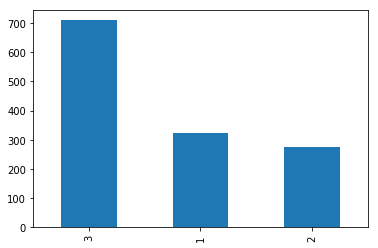

In [789]:
#titanic.pclass.hist(bins=10)
titanic.pclass.value_counts().plot(kind='bar')

In [692]:
titanic.pclass.isnull().values.any()

False

In [693]:
titanic.embarked.isnull().values.any()

True

In [694]:
pd.get_dummies(titanic.embarked).head(10)

,C,Q,S
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


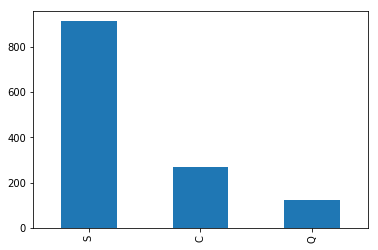

In [795]:
#titanic.embarked.replace({'S': 0, 'Q': 1, 'C': 2}).hist(bins=10)
#pd.get_dummies(titanic.embarked).plot.bar()
titanic.embarked.value_counts().plot(kind='bar')

In [696]:
titanic.sex.isnull().values.any()

False

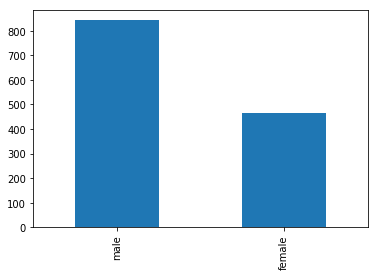

In [791]:
#titanic.sex.replace({'male': 0, 'female': 1}).hist(bins=5)
#plt.xlabel('0 : male       1 : female')
titanic.sex.value_counts().plot(kind='bar')

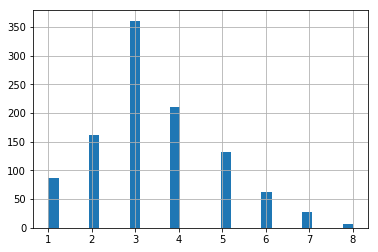

In [799]:
pd.cut(titanic.age, [0,10,20,30,40,50,60,70,80], labels=[1,2,3,4,5,6,7,8]).hist(bins=30)
#pd.cut(titanic.age, [0,10,20,30,40,50,60,70,80], labels=[1,2,3,4,5,6,7,8]).value_counts().plot(kind='bar')

In [702]:
#titanic_cab_grouped = 
titanic.groupby(titanic.cabin)['age'].mean().head()
#titanic_cab_grouped.head()

cabin
A10    36.0
A11    33.0
A14     NaN
A16    48.0
A18    39.0
Name: age, dtype: float64

In [728]:
cabin_floor = titanic.cabin.copy()
cabin_floor = cabin_floor.str.extract('([ABCDEFGOT])').dropna()

/home/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [745]:
titanic4 = titanic.copy()
titanic4['cabin']= cabin_floor
titanic4.rename(columns={'cabin':'cabinFloor'})

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabinFloor,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


In [786]:
cabin_floor_num = titanic4.cabin.value_counts()

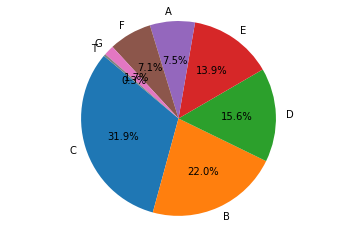

In [787]:
sizes = []
for x in cabin_floor_num:
    sizes.append(x)
labels = cabin_floor_num.keys()
plt.pie(sizes, labels = labels, autopct='%1.1f%%', startangle = 140)
plt.axis('equal')
plt.show()

In [311]:
titanic_grouped = titanic.groupby(titanic.pclass)
survival_rate = lambda x:(x[['survived']].sum()/x.shape[0])
titanic_class_survived = titanic_grouped.apply(survival_rate)
titanic_class_survived

,survived
pclass,
1,0.619195
2,0.429603
3,0.255289


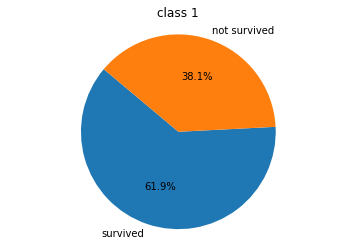

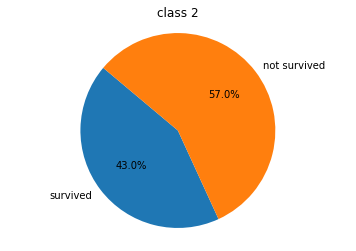

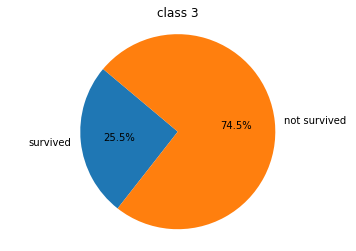

In [306]:
sizes = {}
labels = 'survived', 'not survived'

for x in {1,2,3}:
    sizes[x] = [titanic_class_survived['survived'][x], 1-titanic_class_survived['survived'][x]]
    plt.pie(sizes[x], labels = labels, autopct='%1.1f%%', startangle = 140)
    plt.axis('equal')
    plt.title('class '+str(x))
    plt.show()




In [318]:
titanic_class_sex_survived = titanic.groupby(['pclass','sex'])[['survived']].apply(survival_rate)
titanic_class_sex_survived['survived']

pclass  sex   
1       female    0.965278
        male      0.340782
2       female    0.886792
        male      0.146199
3       female    0.490741
        male      0.152130
Name: survived, dtype: float64

In [713]:
titanic_multiInd = titanic.set_index(['pclass','sex'])
titanic_grouped1 = titanic_multiInd.groupby(level=('pclass','sex'),axis=0)[['survived']].apply(survival_rate)
titanic_grouped1.head()

survived
pclass sex             
1      female  0.965278
       male    0.340782
2      female  0.886792
       male    0.146199
3      female  0.490741

In [706]:
titanic_grouped1.index.is_unique

True

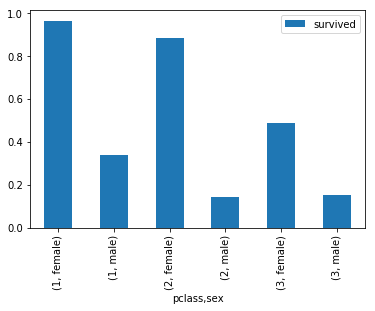

In [711]:
titanic_grouped1.plot.bar()

In [712]:
titanic2 = titanic.copy()
titanic2.dropna(subset=['age'], inplace = True)


In [485]:
age_sorted = sorted(titanic2.age)
length = len(age_sorted)
age_median = age_sorted[int(length/2-1)]  

In [509]:
titanic_ages = pd.cut(titanic.age,[0,age_median,max(age_sorted)],labels=['young','old'])
titanic2['age']=titanic_ages
titanic2[50:200]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
54,1,1,"Carter, Master. William Thornton II",male,young,1,2,113760,120.0000,B96 B98,S,4,NaN,"Bryn Mawr, PA"
55,1,1,"Carter, Miss. Lucile Polk",female,young,1,2,113760,120.0000,B96 B98,S,4,NaN,"Bryn Mawr, PA"
56,1,1,"Carter, Mr. William Ernest",male,old,1,2,113760,120.0000,B96 B98,S,C,NaN,"Bryn Mawr, PA"
57,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,old,1,2,113760,120.0000,B96 B98,S,4,NaN,"Bryn Mawr, PA"
58,1,0,"Case, Mr. Howard Brown",male,old,0,0,19924,26.0000,NaN,S,NaN,NaN,"Ascot, Berkshire / Rochester, NY"
60,1,0,"Cavendish, Mr. Tyrell William",male,old,1,0,19877,78.8500,C46,S,NaN,172.0,"Little Onn Hall, Staffs"
61,1,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,old,1,0,19877,78.8500,C46,S,6,NaN,"Little Onn Hall, Staffs"
62,1,0,"Chaffee, Mr. Herbert Fuller",male,old,1,0,W.E.P. 5734,61.1750,E31,S,NaN,NaN,"Amenia, ND"
63,1,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,old,1,0,W.E.P. 5734,61.1750,E31,S,4,NaN,"Amenia, ND"
64,1,1,"Chambers, Mr. Norman Campbell",male,young,1,0,113806,53.1000,E8,S,5,NaN,"New York, NY / Ithaca, NY"


In [520]:
#titanic_multiInd2 = titanic2.set
titanic_grouped2 = titanic2.groupby(('pclass','sex','age'),axis=0)[['survived']].apply(survival_rate).round(3)
titanic_grouped2.head()
titanic3 = titanic_grouped2.unstack('age')
titanic3

survived       
age              young    old
pclass sex                   
1      female    0.951  0.967
       male      0.531  0.303
2      female    0.911  0.872
       male      0.216  0.083
3      female    0.514  0.372
       male      0.183  0.144

In [521]:
titanic3.index.is_unique

True